# **Avaliando Redações do ENEM - Competência 5**

## **Configurações Iniciais e Carregamento dos Dados**

O primeiro passo é importar as bibliotecas necessárias no decorrer da execução do notebook, além também de importar as funções auxiliares desenvolvidas para encapsular processos comuns durante o desenvolvimento do projeto. Logo após, carregamos os dados referentes às redações e seus textos motivadores para dar início aos procedimentos de análise.

In [1]:
import numpy as np
import pandas as pd
import sklearn as skl
import seaborn as sns
import matplotlib.pyplot as plt

import ast
import nltk
import torch
import spacy
import transformers

from utils import loader
from utils import models
from utils.train import train
from utils.eval import eval
from collections import Counter

c:\Users\luwul\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
essays, prompts = loader.load_data()

display(essays)

,prompt,title,essay,competence,score
0,21,A greve dos caminhoneiros e a malha ferroviária,['A grande importância dos caminhoneiros para ...,"[160, 160, 120, 120, 120]",680
1,23,"Vossa excelência Senador M. M.,",['O senhor e eu já estamos cientes do projeto ...,"[160, 160, 120, 120, 120]",680
2,39,A validade do impeachment,['É de conhecimento geral dos brasileiros o qu...,"[120, 160, 160, 160, 120]",720
3,26,Podemos perceber que a sociedade brasileira,['Podemos perceber que a sociedade brasileira ...,"[120, 120, 80, 120, 120]",560
4,4,Comenta-se que o ex-presidente Lula,['Comenta-se que o ex presidente Lula ex-presi...,"[0, 0, 0, 0, 0]",0
...,...,...,...,...,...
4565,43,redes sociais,"['Em constante evolução tecnológica , o mundo ...","[160, 120, 120, 120, 120]",640
4566,60,Reforma da Previdência uma solução para o Brasil.,"['“O importante da vida não é viver, mas viver...","[120, 80, 80, 120, 80]",480
4567,44,"lados opostos, mesmo problema",['O esporte – seja qual for – é comporto por r...,"[160, 200, 160, 200, 200]",920
4568,49,Da Ficção à Realidade,"['José Saramago, proeminente escritor e dramat...","[160, 160, 160, 160, 160]",800


## **Explorando a natureza dos dados**

Afim de conhecer melhor as características dos dados com que estamos trabalhando, investigamos as redações e suas respectivas notas. Observando algumas redações, é possível notar que essas foram armazenadas, quebrando seu conteúdo na forma de parágrafos, e temos disponível uma lista contendo esses parágrafos em uma única string.

In [22]:
sample = essays['essay'].head(1)

for s in sample:
    display(ast.literal_eval(s))

['A grande importância dos caminhoneiros para o país foi perceptível por todos durante a greve, que recebeu o apoio de 87% dos brasileiros, de acordo com uma pesquisa DataFolha . Porém, existem alternativas mais inteligentes e sustentáveis que o transporte rodoviário de mercadorias, como por exemplo o transporte por malhas ferroviárias.',
 'A escassez de alimento e de combustíveis em todo o país foram apontados como consequência da falta de transporte dessas mercadorias por conta da paralisação dos caminhoneiros. Porém, essa escassez só ocorreu devido ao desespero das pessoas que acabaram comprando quantidades exageradas de alimento, sendo necessário que as redes de supermercado limitassem a quantidade de produtos por pessoa que poderia ser comprado. No caso dos combustíveis, muitos optaram por garantir o abastecimento dos seus automóveis se submetendo a pagar valores altos para isso.',
 'Por outro lado, a minoria das pessoas não se entregou para os problemas enfrentados pela greve e o

Analisando mais profundamente essa divisao em paragrafos, eh perceptivel a diferenca de formatacao entre as redacoes que possuimos como dados. A maior concentração do volume de redações apresenta 4 parágrafos, com redações de 5 e 3 parágrafos sendo as mais comuns logo em seguida. Vale notar também que existem algumas redações que foram armazenadas em até 34 parágrafos, o que indica que alguns dados provavelmente foram coletados com ruídos e imprecisões. Felizmente, essa parcela de dados ruidosos representa um volume relativamente pequeno no conjunto completo.

C:\Users\luwul\AppData\Local\Temp\ipykernel_13584\1350918386.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=n_paragraphs, palette='viridis')


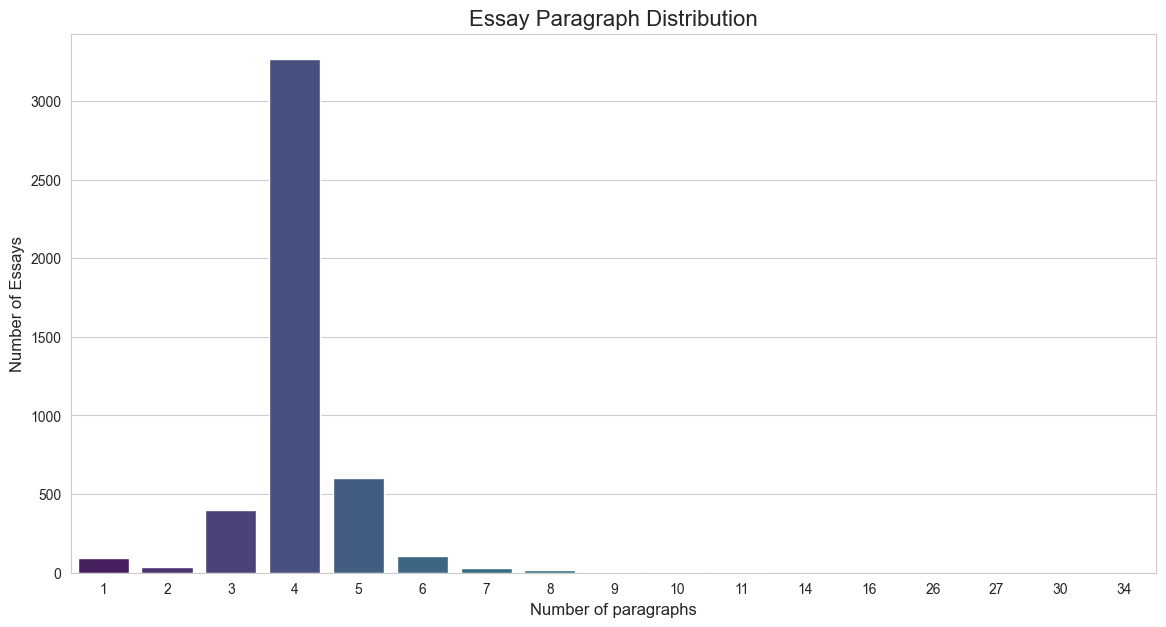

In [23]:
n_paragraphs = []

for row in essays['essay']:
    n_paragraphs.append(len(ast.literal_eval(row)))

n_paragraphs = Counter(n_paragraphs)

sns.set_style("whitegrid")

plt.figure(figsize=(14, 7))
sns.barplot(data=n_paragraphs, palette='viridis')
plt.title('Essay Paragraph Distribution', fontsize=16)
plt.xlabel('Number of paragraphs', fontsize=12)
plt.ylabel('Number of Essays', fontsize=12)

plt.show()

Entendendo a organização das informações referentes ao conteúdo da redação, seguimos para algumas análises referentes às notas. Olhamos para a distribuição das notas que as redações atingiram na competência 5, sendo a competência analisada nessa etapa do projeto. Vemos que a maioria das redações atinge uma nota de 120 pontos na competência, com a segunda nota mais comum sendo 80 pontos. Essa distribuição era esperada, que o maior volume de notas se concentrasse nas categorias intermediárias.

C:\Users\luwul\AppData\Local\Temp\ipykernel_13584\3525559979.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grades, palette='viridis')


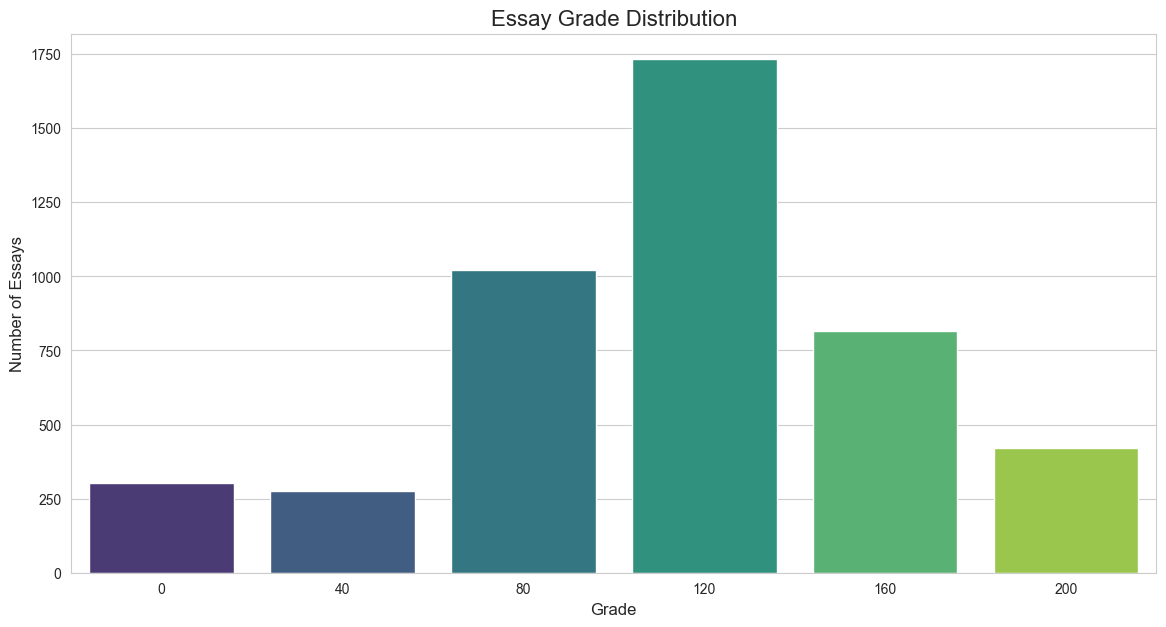

In [24]:
grades = []

for row in essays['competence']:
    grades.append(ast.literal_eval(row)[4])


grades = Counter(grades)

sns.set_style("whitegrid")

plt.figure(figsize=(14, 7))
sns.barplot(data=grades, palette='viridis')
plt.title('Essay Grade Distribution', fontsize=16)
plt.xlabel('Grade', fontsize=12)
plt.ylabel('Number of Essays', fontsize=12)

plt.show()

Seguindo um pouco mais profundamente na análise das pontuações, visto a variabilidade de número de parágrafos que podemos encontrar, analisamos a nota média atribuída baseada na formatação na qual a redação se encontra armazenada. A análise foi limitada a um certo limiar na contagem dos parágrafos, desta forma descartando os dados que possivelmente são ruidosos. As melhores pontuações na média provêm de redações com 4 e 5 parágrafos, que coincidem com a formatação dos modelos de redações que são recomendados para o teste.

C:\Users\luwul\AppData\Local\Temp\ipykernel_13584\1401540332.py:9: RuntimeWarning: invalid value encountered in divide
  avg_grades = grades/essay_count
C:\Users\luwul\AppData\Local\Temp\ipykernel_13584\1401540332.py:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=avg_grades, palette='viridis')


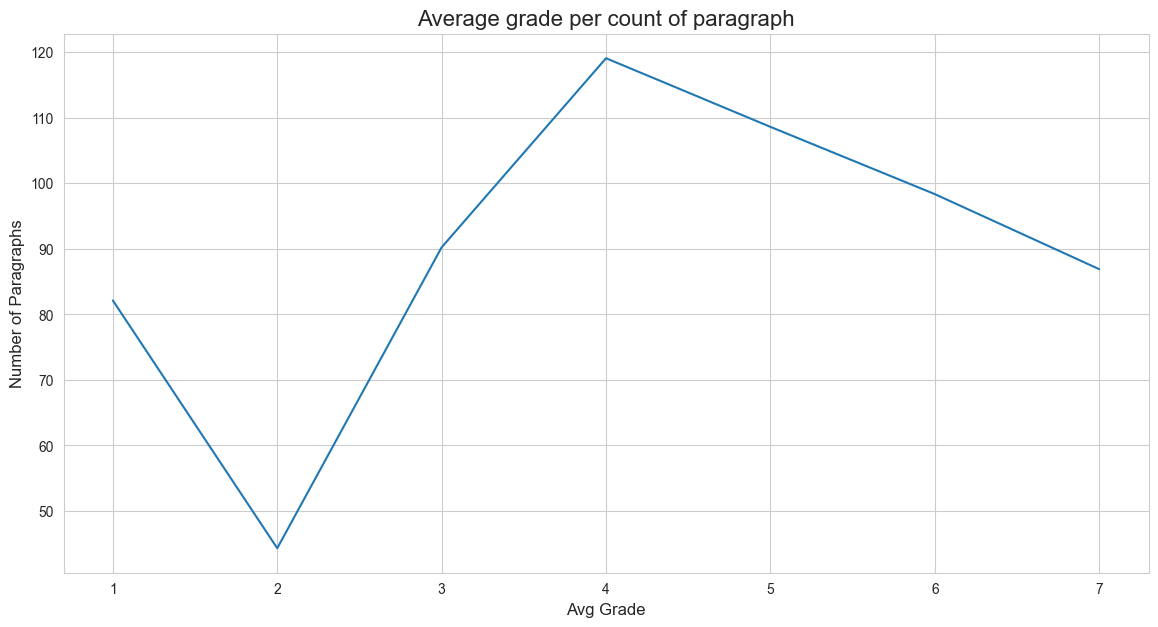

In [25]:

grades = np.zeros(8)
essay_count = np.zeros(8)

for i, row in essays.iterrows():
    if len(ast.literal_eval(row['essay'])) < 8:
        essay_count[len(ast.literal_eval(row['essay']))-1] += 1
        grades[len(ast.literal_eval(row['essay']))-1]  += ast.literal_eval(row['competence'])[4] 

avg_grades = grades/essay_count   

plt.figure(figsize=(14, 7))
sns.lineplot(data=avg_grades, palette='viridis')
plt.title('Average grade per count of paragraph', fontsize=16)
plt.xlabel('Avg Grade', fontsize=12)
plt.xticks(range(0,7),range(1,8))
plt.ylabel('Number of Paragraphs', fontsize=12)

plt.show()

A decisão de filtragem do conjunto na análise anterior para eliminar os dados ruidosos será fixada para o restante do desenvolvimento deste projeto, trabalhando apenas com esse conjunto filtrado.

In [3]:
filter = []

for i, row in essays.iterrows():
    if len(ast.literal_eval(row['essay'])) in range(1,8):
        filter.append(i)

filtered_essays = essays.iloc[filter]

display(filtered_essays)

,prompt,title,essay,competence,score
0,21,A greve dos caminhoneiros e a malha ferroviária,['A grande importância dos caminhoneiros para ...,"[160, 160, 120, 120, 120]",680
1,23,"Vossa excelência Senador M. M.,",['O senhor e eu já estamos cientes do projeto ...,"[160, 160, 120, 120, 120]",680
2,39,A validade do impeachment,['É de conhecimento geral dos brasileiros o qu...,"[120, 160, 160, 160, 120]",720
3,26,Podemos perceber que a sociedade brasileira,['Podemos perceber que a sociedade brasileira ...,"[120, 120, 80, 120, 120]",560
4,4,Comenta-se que o ex-presidente Lula,['Comenta-se que o ex presidente Lula ex-presi...,"[0, 0, 0, 0, 0]",0
...,...,...,...,...,...
4565,43,redes sociais,"['Em constante evolução tecnológica , o mundo ...","[160, 120, 120, 120, 120]",640
4566,60,Reforma da Previdência uma solução para o Brasil.,"['“O importante da vida não é viver, mas viver...","[120, 80, 80, 120, 80]",480
4567,44,"lados opostos, mesmo problema",['O esporte – seja qual for – é comporto por r...,"[160, 200, 160, 200, 200]",920
4568,49,Da Ficção à Realidade,"['José Saramago, proeminente escritor e dramat...","[160, 160, 160, 160, 160]",800


## **Abordagem 1: Analisando o Texto Completo**

A primeira abordagem para solucionar esta tarefa de pontuação automática é trabalhar sobre o texto todo de maneira direta. Utilizando o modelo BERTimbau, que foi treinado especificamente na língua portuguesa, extraímos os embeddings quebrando os respectivos parágrafos em sentenças com a ajuda da biblioteca NLTK. Essa representação das sentenças é agrupada em uma lista que posteriormente forma a representação do texto completo em sua totalidade.

O tamanho de um texto é completamente variável, tal característica leva à necessidade de uma padronização nas dimensões das representações extraídas. Uma estratégia de padding com zeros foi adotada a fim de preencher a representação dos textos e garantir que o tamanho seja uniforme entre eles.

In [ ]:
from transformers import pipeline
from utils.loader import categorize_score
from nltk.tokenize import sent_tokenize


nltk.download('punkt')

tokenizer = transformers.AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = transformers.AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')


tokenizer.model_max_length = model.config.max_position_embeddings

extractor = pipeline(
        "feature-extraction",
        model=model,
        tokenizer=tokenizer,
        framework="pt",
        truncation=True,
        max_length=tokenizer.model_max_length
    )

text_embeddings = []
text_labels = []

for index, row in filtered_essays.iterrows():
    text = ast.literal_eval(row['essay'])

    sentence_embeddings = []
    for paragraph in text:
        sentencas = sent_tokenize(paragraph, language='portuguese')
        for sentenca in sentencas:
            sentence_embeddings.append(np.mean(extractor(sentenca.lower())[0], axis=0))

    text_embeddings.append(sentence_embeddings)
    text_labels.append(categorize_score(ast.literal_eval(row['competence'])[4]))




max_len = max(len(e) for e in text_embeddings)
hidden_size = model.config.hidden_size
padded_embeddings = [e + [np.zeros(hidden_size, dtype=np.float32)] * (max_len - len(e)) for e in text_embeddings]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\luwul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## **Abordagem 2: Analisando as Sentencas Relevantes**

Outro método proposto para o desenvolvimento de uma solução é a análise sobre um conjunto de sentenças que sejam relevantes para a construção da intervenção que a competência 5 analisa. Essa seleção foi elaborada seguindo a construção encontrada nos modelos recomendados de redação, com expressões comuns que conectam as ideias analisadas na competência.

Também foi levado em conta a citação de entidades e órgãos externos, que é uma obrigatoriedade na correção da competência. Para isso, foi executada uma etapa de preprocessamento em todas as redações, aplicando técnicas de NER e extraindo as entidades e organizações encontradas.

In [4]:
intervencao = [
    # Ação
    "promova",
    "implemente",
    "crie",
    "ofereça",
    "desenvolva",
    "fomentar",
    "estabelecer",
    "ampliar",
    "conscientizar",
    "capacitar",
    "realize",
    "incentive",
    "fiscalize",
    "disponibilize",
    # Agente
    "sociedade civil",
    "mídia",
    "escolas",
    "universidades",
    "famílias",
    "cidadãos",
    "instituições de ensino",
    # Meio/Modo
    "por meio de",
    "atraves de",
    "mediante",
    "por intermédio de",
    "com o intuito de",
    "valendo-se de",
    "empregando",
    "utilizando",
    "lançando mão de",
    "com o auxílio de",
    # Finalidade/Efeito
    "para que",
    "assim",
    "com o objetivo de",
    "a fim de",
    "visando",
    "de modo a",
    "a fim de que",
    "a fim de combater",
    "a fim de reduzir",
    "a fim de promover",
    "a fim de garantir",
    "para que se possa",
    "a fim de proporcionar",
    # Detalhamento (exemplos de como indicar um detalhamento)
    "como, por exemplo,",
    "a exemplo de,",
    "neste sentido,",
    "para tanto,",
    "o que inclui",
    "especialmente"
]

spacy_pipeline = spacy.load("pt_core_news_sm")

for index, row in filtered_essays.iterrows():
    text = ast.literal_eval(row['essay'])

    intervencao.extend([i.text.lower() for i in spacy_pipeline(" ".join(text)).ents])


#display(intervencao)

c:\Users\luwul\AppData\Local\Programs\Python\Python310\lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'pt_core_news_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Usando esse filtro de expressões e entidades, aplicamos ele sobre as sentenças presentes no texto a fim de selecionar aquelas que podem possuir informações relevantes para a análise da proposta de intervenção. Isso reduz significativamente o volume da representação vetorial quando comparado com a abordagem anterior, visto que essa abordagem não trabalha sobre todas as informações. Contudo, ainda é necessário o processo de padronização do tamanho das representações, pois o número de sentenças relevantes encontradas é variável.

In [5]:
from transformers import pipeline
from utils.loader import categorize_score
from nltk.tokenize import sent_tokenize

nltk.download('punkt')

tokenizer = transformers.AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = transformers.AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')


tokenizer.model_max_length = model.config.max_position_embeddings

extractor = pipeline(
        "feature-extraction",
        model=model,
        tokenizer=tokenizer,
        framework="pt",
        truncation=True,
        max_length=tokenizer.model_max_length
    )

text_embeddings = []
text_labels = []
for index, row in filtered_essays.iterrows():
    text = ast.literal_eval(row['essay'])

    sentence_embeddings = []
    for paragraph in text:
        sentencas = sent_tokenize(paragraph, language='portuguese')
        for sentenca in sentencas:
            for palavra in sentenca.split():
                if palavra.lower() in intervencao:
                    #print(f">> Token detected {palavra}, adding sentence")
                    sentence_embeddings.append(np.mean(extractor(sentenca.lower())[0], axis=0))
                    break

    text_embeddings.append(sentence_embeddings)
    text_labels.append(categorize_score(ast.literal_eval(row['competence'])[4]))

max_len = max(len(e) for e in text_embeddings)
hidden_size = model.config.hidden_size
padded_embeddings = [e + [np.zeros(hidden_size, dtype=np.float32)] * (max_len - len(e)) for e in text_embeddings]

W0710 15:16:22.432954 17560 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\luwul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## **Abordagem 3: Analisando os Paragrafos Relevantes**

Seguindo uma ideia similar à da abordagem anterior, nesta também é realizada uma etapa de filtragem a fim de selecionar as informações relevantes do texto. O desenvolvimento da proposta de intervenção geralmente se encontra no parágrafo que conclui a redação, portanto tal parágrafo se faz o mais interessante para análise, onde o objetivo é avaliar a competência 5.

A variância na formatação das redações encontradas apresenta um desafio à detecção do parágrafo que contém a proposta de intervenção, pois mesmo que comumente seja o encerramento do texto, ainda existem alguns casos onde outras informações se encontram na finalização ao invés da conclusão. Tendo isso em mente, a escolha do parágrafo é feita com base em regras que verificam a existência de conectivos que são empregados ao iniciar-se a construção de uma ideia conclusiva.

In [18]:
conectivos = [
    "Portanto",
    "Logo",
    "Assim",
    "Em conclusão",
    "Por conseguinte",
    "Dessa forma",
    "Em suma",
    "Em síntese",
    "Por fim",
    "Diante do exposto",
    "Assim sendo",
    "Dessa maneira"
]

In [ ]:
from transformers import pipeline
from utils.loader import categorize_score
from nltk.tokenize import sent_tokenize


nltk.download('punkt')

tokenizer = transformers.AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = transformers.AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')


tokenizer.model_max_length = model.config.max_position_embeddings

extractor = pipeline(
        "feature-extraction",
        model=model,
        tokenizer=tokenizer,
        framework="pt",
        truncation=True,
        max_length=tokenizer.model_max_length
    )

text_embeddings = []
text_labels = []

for index, row in filtered_essays.iterrows():
    text = ast.literal_eval(row['essay'])

    sentence_embeddings = []
    for paragraph in text:
        sentencas = sent_tokenize(paragraph, language='portuguese')
        if any(conectivo.lower() in paragraph.lower() for conectivo in conectivos):
            for sentenca in sentencas:
                sentence_embeddings.append(np.mean(extractor(sentenca.lower())[0], axis=0))

    text_embeddings.append(sentence_embeddings)
    text_labels.append(categorize_score(ast.literal_eval(row['competence'])[4]))




max_len = max(len(e) for e in text_embeddings)
hidden_size = model.config.hidden_size
padded_embeddings = [e + [np.zeros(hidden_size, dtype=np.float32)] * (max_len - len(e)) for e in text_embeddings]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\luwul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## **Treinando um Modelo de Classificação**

Usando como base as características extraídas e representadas na forma de embeddings, invocamos uma função auxiliar que compreende o carregamento das representações em DataLoaders da biblioteca torch. Os DataLoaders são gerados de forma que 80% dos dados são dedicados para treino e 20% deles dedicados para teste. Para avaliar as redações a partir da representação por embeddings, escolhemos por iniciar com o treinamento de uma cabeça de classificação rasa. 

In [6]:
train_loader, test_loader = loader.embeddings_into_dataloader(
    np.array([np.concatenate(e) for e in padded_embeddings]), 
    np.array(text_labels)
    )
device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = max_len * hidden_size

classHead = models.ClassificationHead(input_size=input_size, targets=6)
print(f"\nModel architecture:\n{classHead}")


Model architecture:
ClassificationHead(
  (fc): Sequential(
    (0): Linear(in_features=31488, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=6, bias=True)
  )
)


O looping de treinamento utiliza o otimizador AdamW para aprimorar o modelo de classificação treinado, seguindo os hiperparâmetros definidos no corpo da função. Alguns dos hiperparâmetros foram fixados nos valores padrões que são comumente utilizados em tarefas similares, e outros foram incorporados aos parâmetros da função para permitir variações durante os treinamentos entre as diferentes abordagens. 

Algo observado logo nos primeiros treinamentos foi a facilidade do modelo de se adaptar aos dados de treinamento, ocorrendo assim o caso de overfitting. Afim de minimizar essa adaptação tão veloz e permitir ao modelo aprender uma distribuição mais generalista que desempenhe melhor nos casos de teste, adicionamos uma regularização L2 com decaimento de pesos no otimizador.

In [7]:
train(
    model=classHead,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    num_epochs=50,
    lr=2e-5,
    weight_decay=0.001
)


--- Starting Training ---
|-> Epoch [1/50], Loss: 6.0590, Train Accuracy: 0.3944
|-> Epoch [2/50], Loss: 5.6874, Train Accuracy: 0.4192
|-> Epoch [3/50], Loss: 5.4512, Train Accuracy: 0.4523
|-> Epoch [4/50], Loss: 5.2384, Train Accuracy: 0.4735
|-> Epoch [5/50], Loss: 5.0725, Train Accuracy: 0.5000
|-> Epoch [6/50], Loss: 4.8772, Train Accuracy: 0.5209
|-> Epoch [7/50], Loss: 4.7287, Train Accuracy: 0.5416
|-> Epoch [8/50], Loss: 4.5814, Train Accuracy: 0.5639
|-> Epoch [9/50], Loss: 4.4437, Train Accuracy: 0.5736
|-> Epoch [10/50], Loss: 4.3276, Train Accuracy: 0.5945

--- Evaluation on Test Set ---
Final Test Accuracy: 0.4570
Final Test QWK: 0.2216
Final Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.10      0.17        61
           1       0.00      0.00      0.00        56
           2       0.39      0.43      0.41       206
           3       0.45      0.78      0.57       330
           4       0.53      0.18     

O modelo é avaliado em seu desempenho sobre diferentes óticas, utilizando tanto uma taxa de acerto simples como a métrica QWK que leva em consideração a distância entre a ordem das classes na ponderação do erro. Além de também analisarmos um relatório contendo a precisão, revocação e F-Medida.

In [9]:
eval(model=classHead, test_loader=test_loader, device=device)


--- Evaluation on Test Set ---
Final Test Accuracy: 0.3943
Final Test QWK: 0.1719
Final Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.13      0.20        61
           1       0.19      0.05      0.08        56
           2       0.33      0.39      0.36       206
           3       0.44      0.55      0.49       330
           4       0.34      0.30      0.32       170
           5       0.60      0.39      0.47        85

    accuracy                           0.39       908
   macro avg       0.38      0.30      0.32       908
weighted avg       0.39      0.39      0.38       908



In [ ]:
models.save_model(classHead,"sample")